In [75]:
!pip install pymc

In [76]:
import numpy as np
from matplotlib import pyplot as plt
import pymc as pm

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


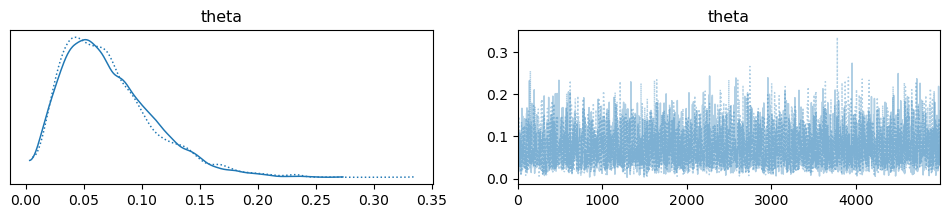

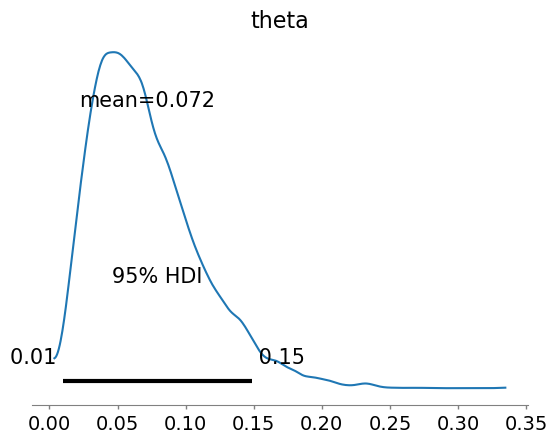

In [128]:
N = 40 # アリスのデザインA案の表示回数
a = 2 # アリスのデザインA案のクリック数

with pm.Model() as model:
    theta = pm.Uniform("theta", lower = 0, upper = 1)
    obs = pm.Binomial("a", p = theta, n = N, observed = a)
    trace = pm.sample(5000, chains = 2)

with model:
    pm.plot_trace(trace)

with model:
    pm.plot_posterior(trace, hdi_prob = 0.95)

In [129]:
with model:
    print(pm.summary(trace, hdi_prob = 0.95))

        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
theta  0.072  0.039      0.01      0.149      0.001      0.0    4201.0   

       ess_tail  r_hat  
theta    4279.0    1.0  


In [130]:
# 仮説: アリスのデザインA案のクリック率は1%以上である
# 評価: 新たな確率変数δ = θ - 0.01のサンプルが95%の確率で正の値になる
# 結果: 0.9949のため、アリスのデザインA案のクリック率は1%以上である
with model:
    print((trace.posterior["theta"].values - 0.01 > 0).mean())

0.9949


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


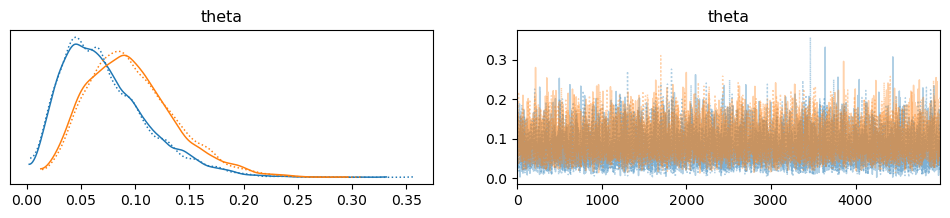

In [131]:
# A案とB案を同時に指定
with pm.Model() as alice_model:
    theta = pm.Uniform("theta", lower = 0, upper = 1, shape = 2)
    obs = pm.Binomial("obs", p = theta, n = [40, 50], observed = [2, 4])
    trace = pm.sample(5000, chains = 2)

with alice_model:
    pm.plot_trace(trace, ["theta"], compact = True)

In [132]:
# 仮説: デザインB案のクリック率はデザインA案よりも大きい
# 評価: δ = θb - θaのサンプルが95%の確率で正の値になる
with alice_model:
    print((trace.posterior['theta'][:, :, 1] - trace.posterior['theta'][:, :, 0] > 0).mean())

<xarray.DataArray 'theta' ()> Size: 8B
array(0.6788)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


<xarray.DataArray 'theta' ()> Size: 8B
array(0.9993)


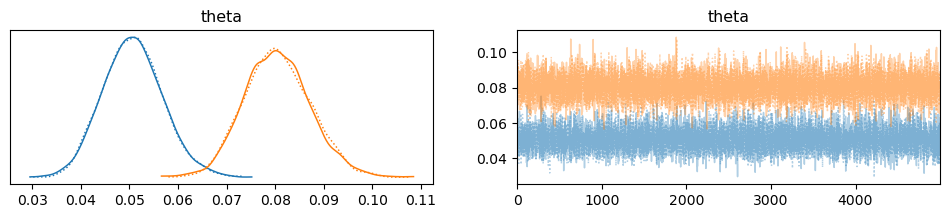

In [133]:
# ボブのデザイン案
with pm.Model() as bob_model:
    theta = pm.Uniform("theta", lower = 0, upper = 1, shape = 2)
    obs = pm.Binomial("obs", p = theta, n = [1280, 1600], observed = [64, 128])
    trace = pm.sample(5000, chains = 2)
    print((trace.posterior['theta'][:, :, 1] - trace.posterior['theta'][:, :, 0] > 0).mean())
    pm.plot_trace(trace, ["theta"], compact = True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


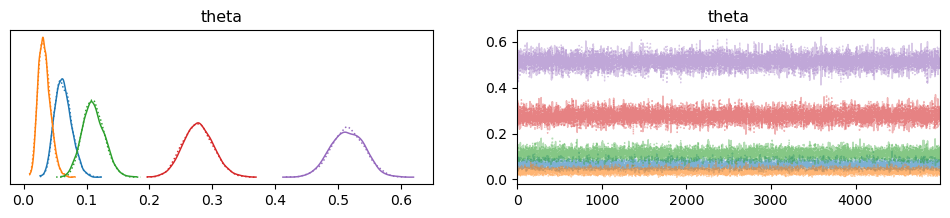

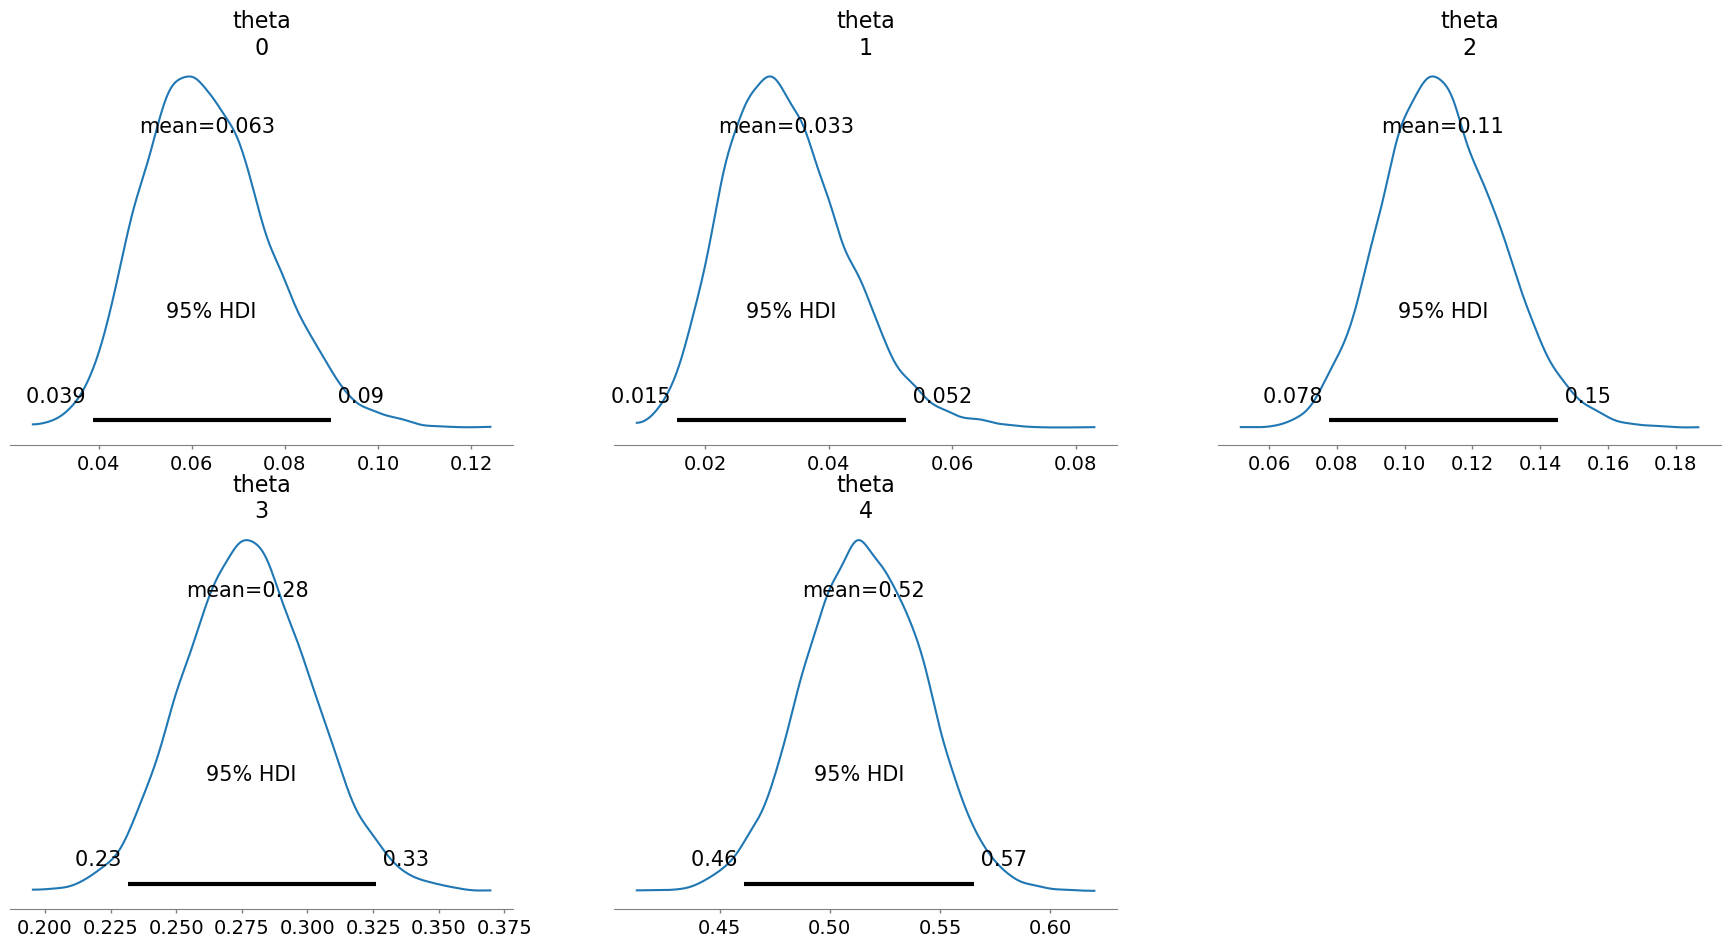

In [134]:
# 真のレビュースコア
# 商品A
n_a = [20, 10, 36, 91, 170]
data = [0 for _ in range(n_a[0])] # レビュースコア1点
data += [1 for _ in range(n_a[1])] # レビュースコア2点
data += [2 for _ in range(n_a[2])] # レビュースコア3点
data += [3 for _ in range(n_a[3])] # レビュースコア4点
data += [4 for _ in range(n_a[4])] # レビュースコア5点

# 尤度関数: カテゴリカル分布
# 事前分布: ディリクレ分布(ここでは多カテゴリの一様分布で設定)
with pm.Model() as model_a:
    theta = pm.Dirichlet("theta", a = np.array([1, 1, 1, 1, 1]))
    obs = pm.Categorical("obs", p = theta, observed = data)
    trace_a = pm.sample(5000, chains = 2)

with model_a:
    pm.plot_trace(trace_a)
    pm.plot_posterior(trace_a, hdi_prob = 0.95)

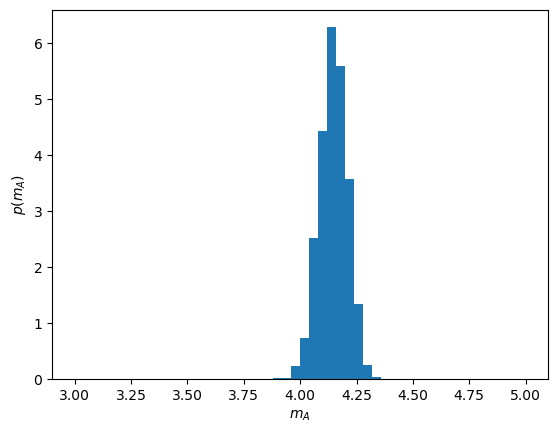

In [136]:
# レビュースコアの平均点の分布
# レビュースコアの平均点に相当する確率変数mを導入
# m = 各レビュースコアをそれが発生する確率の重みで加重平均する
weights = np.array([1, 2, 3, 4, 5])
m_a = [sum(row * weights) for row in trace_a.posterior['theta'].values[0, :, :]]

plt.hist(m_a, range = (3, 5), bins = 50, density = True)
plt.xlabel(r'$m_A$')
plt.ylabel(r'$p(m_A)$')
plt.show()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


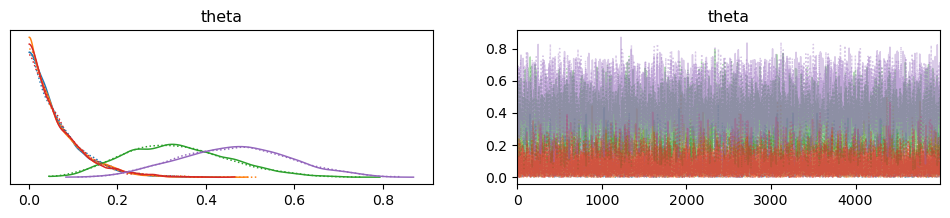

In [137]:
# 商品B
# カテゴリカル分布を多項分布に変更
n_b = np.array([0, 0, 4, 0, 6])
with pm.Model() as model_b:
    theta = pm.Dirichlet("theta", a = np.array([1, 1, 1, 1, 1]))
    obs = pm.Multinomial("obs", p = theta, n = n_b.sum(), observed = n_b)
    trace_b = pm.sample(5000, chains = 2)
    pm.plot_trace(trace_b)

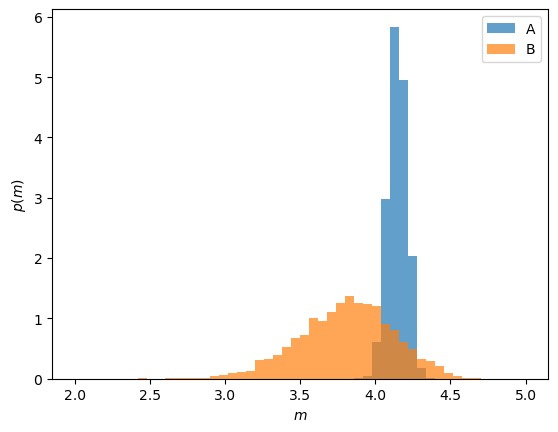

In [139]:
m_b = [sum(row * weights) for row in trace_b.posterior['theta'].values[0, :, :]]
plt.hist(m_a, range = (2, 5), bins = 50, density = True, label = "A", alpha = 0.7)
plt.hist(m_b, range = (2, 5), bins = 50, density = True, label = "B", alpha = 0.7)
plt.xlabel(r'$m$')
plt.ylabel(r'$p(m)$')
plt.legend()
plt.show()

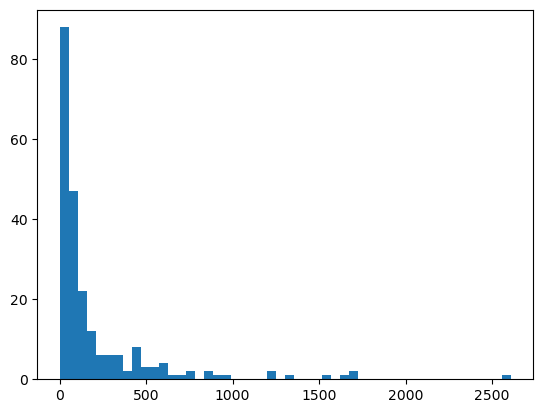

In [141]:
# 滞在時間をテストする
import urllib
url = "https://www.oreilly.co.jp/pub/9784873119168/data/time-on-page.csv"
response = urllib.request.urlopen(url)
data = [int(row.strip()) for row in response.readlines()]
plt.hist(data, bins = 50)
plt.show()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


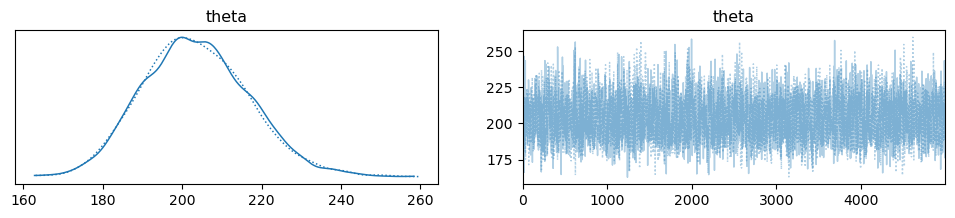

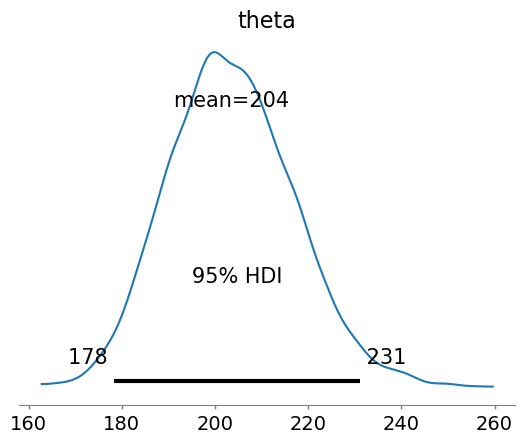

In [145]:
# 指数分布
with pm.Model() as model:
    theta = pm.Uniform("theta", lower = 0, upper = 3000)
    obs = pm.Exponential("obs", lam = 1/theta, observed = data)
    trace = pm.sample(5000, chains = 2)
    pm.plot_trace(trace)
    pm.plot_posterior(trace, hdi_prob = 0.95)